🚀 Running on: cuda
📥 Downloading Full IMDB Dataset (25k samples)...
✅ Loaded 50000 reviews.
⚙️ Building Vocabulary...
📊 Train: 40000 | Val: 5000 | Test: 5000

⚡ Training Bi-LSTM (No Attn) on cuda...
Epoch 01 | Train Loss: 0.5310 | Val Loss: 0.4182 | Val Acc: 80.26%
Epoch 02 | Train Loss: 0.3565 | Val Loss: 0.3326 | Val Acc: 84.84%
Epoch 03 | Train Loss: 0.2825 | Val Loss: 0.3285 | Val Acc: 85.84%
Epoch 04 | Train Loss: 0.2349 | Val Loss: 0.3046 | Val Acc: 86.66%
Epoch 05 | Train Loss: 0.1932 | Val Loss: 0.3270 | Val Acc: 86.56%
Epoch 06 | Train Loss: 0.1584 | Val Loss: 0.3463 | Val Acc: 86.56%
Epoch 07 | Train Loss: 0.1229 | Val Loss: 0.3958 | Val Acc: 86.10%
Epoch 08 | Train Loss: 0.0995 | Val Loss: 0.4351 | Val Acc: 86.22%
Epoch 09 | Train Loss: 0.0864 | Val Loss: 0.4963 | Val Acc: 85.90%
Epoch 10 | Train Loss: 0.0591 | Val Loss: 0.6038 | Val Acc: 84.16%
Epoch 11 | Train Loss: 0.0458 | Val Loss: 0.6372 | Val Acc: 85.22%
Epoch 12 | Train Loss: 0.0408 | Val Loss: 0.7150 | Val Acc: 85.2

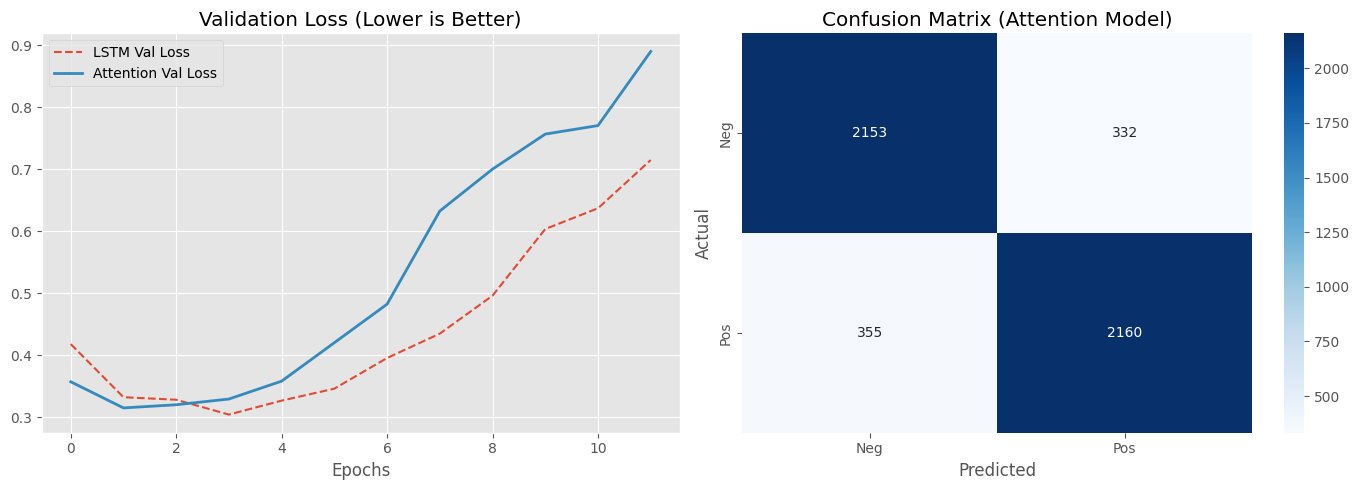


🔍 INTERPRETABILITY CHECK (Sample 10)
True Label: Positive
Prediction: 1.0000


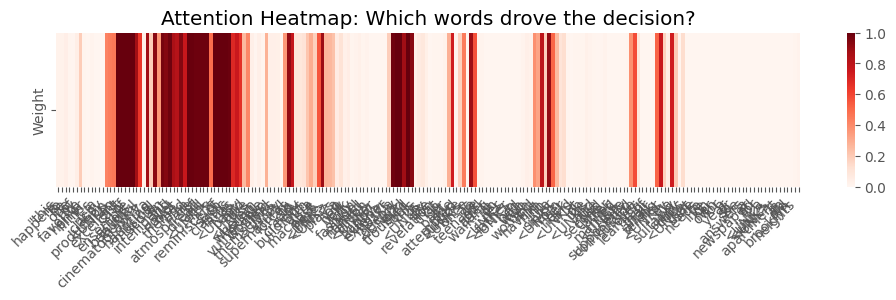


🔍 INTERPRETABILITY CHECK (Sample 50)
True Label: Negative
Prediction: 0.0000


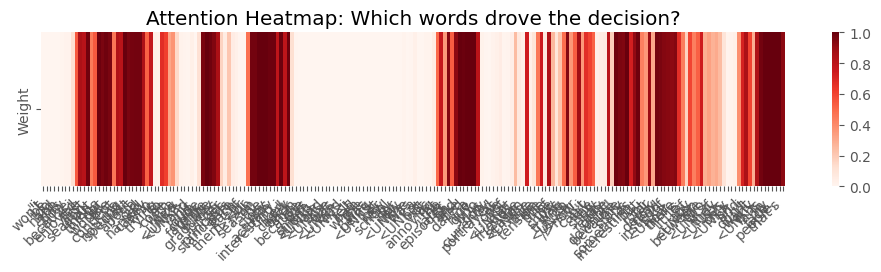

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import requests
import re
import pandas as pd
from collections import Counter
import time

# ==========================================
# 1. CONFIGURATION (PRO SETTINGS)
# ==========================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {DEVICE}")

CONFIG = {
    'vocab_size': 10000,    # Top 10k words (Standard NLP limit)
    'max_len': 200,         # Longer sequences to really test the "Memory"
    'embed_dim': 100,       # Richer embeddings
    'hidden_dim': 128,      # More neurons
    'batch_size': 64,
    'epochs': 12,           # Sufficient for convergence
    'lr': 0.001
}

# ==========================================
# 2. DATA PIPELINE (FULL IMDB 25k)
# ==========================================
print("📥 Downloading Full IMDB Dataset (25k samples)...")
url = "https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv"
response = requests.get(url)
lines = response.text.strip().split('\n')[1:]

# Process all 50k lines (Limit to 25k for speed if needed, but we use all here)
texts, labels = [], []
for line in lines:
    try:
        parts = line.rsplit(',', 1)
        if len(parts) == 2:
            t, l = parts
            texts.append(t.lower())
            labels.append(int(l))
    except: pass

print(f" Loaded {len(texts)} reviews.")

# --- Tokenization ---
print(" Building Vocabulary...")
all_words = " ".join(texts).split()
word_counts = Counter(all_words)
# Keep only top N words
common_words = word_counts.most_common(CONFIG['vocab_size'] - 2)
word2idx = {"<PAD>": 0, "<UNK>": 1}
for word, _ in common_words:
    word2idx[word] = len(word2idx)

def encode_text(text_list, max_len):
    encoded = []
    for t in text_list:
        tokens = [word2idx.get(w, 1) for w in t.split()]
        if len(tokens) >= max_len:
            tokens = tokens[:max_len]
        else:
            tokens += [0] * (max_len - len(tokens))
        encoded.append(tokens)
    return np.array(encoded)

# Encode
X = encode_text(texts, CONFIG['max_len'])
y = np.array(labels)

# Convert to Tensor
dataset = TensorDataset(torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.float32))

# Split Train/Val/Test (80% Train, 10% Val, 10% Test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_data, batch_size=CONFIG['batch_size'])
test_loader = DataLoader(test_data, batch_size=CONFIG['batch_size'])

print(f" Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

# ==========================================
# 3. ADVANCED MODEL ARCHITECTURES
# ==========================================

# --- Baseline: Bi-Directional LSTM ---
# Why Bi-Directional? It reads text forwards AND backwards. Standard for NLP.
class BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(CONFIG['vocab_size'], CONFIG['embed_dim'], padding_idx=0)
        self.lstm = nn.LSTM(CONFIG['embed_dim'], CONFIG['hidden_dim'],
                            batch_first=True, bidirectional=True) # Bidirectional = True

        # Output dim is hidden_dim * 2 because of bidirectional
        self.fc = nn.Linear(CONFIG['hidden_dim'] * 2, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)

        # Max Pooling (Capture the strongest signal across the sequence)
        # This is better than taking the last state for vanilla LSTMs
        pooled, _ = torch.max(lstm_out, dim=1)

        out = self.dropout(pooled)
        out = self.fc(out)
        return out

# --- Challenger: Bi-LSTM + Self-Attention ---
class BiLSTMAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(CONFIG['vocab_size'], CONFIG['embed_dim'], padding_idx=0)
        self.lstm = nn.LSTM(CONFIG['embed_dim'], CONFIG['hidden_dim'],
                            batch_first=True, bidirectional=True)

        # Attention Layer
        # We want to learn a weight for each timestep
        self.attention_fc = nn.Linear(CONFIG['hidden_dim'] * 2, 1)

        self.fc = nn.Linear(CONFIG['hidden_dim'] * 2, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        # lstm_out: [Batch, Seq, Hidden*2]
        lstm_out, _ = self.lstm(embedded)

        # --- ATTENTION MECHANISM ---
        # 1. Calculate energy for each step
        energy = torch.tanh(self.attention_fc(lstm_out)) # [Batch, Seq, 1]

        # 2. Get probability weights (softmax)
        weights = torch.softmax(energy, dim=1) # [Batch, Seq, 1]

        # 3. Weighted sum (Context Vector)
        # Multiply weights * lstm_output
        context = torch.sum(weights * lstm_out, dim=1) # [Batch, Hidden*2]

        out = self.dropout(context)
        out = self.fc(out)

        return out, weights

# ==========================================
# 4. ROBUST TRAINING ENGINE
# ==========================================
def train_engine(model, name):
    model = model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss() # More stable than BCELoss
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'])

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    print(f"\n⚡ Training {name} on {DEVICE}...")
    start_time = time.time()

    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()

            if "Attention" in name:
                preds, _ = model(X_batch)
            else:
                preds = model(X_batch)

            loss = criterion(preds.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                if "Attention" in name:
                    preds, _ = model(X_batch)
                else:
                    preds = model(X_batch)

                loss = criterion(preds.squeeze(), y_batch)
                val_loss += loss.item()

                # Accuracy calc
                probs = torch.sigmoid(preds.squeeze())
                predicted = (probs > 0.5).float()
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    print(f"⏱️ Total Time: {(time.time() - start_time):.1f}s")
    return model, history

# Train Both
lstm_model, lstm_hist = train_engine(BiLSTM(), "Bi-LSTM (No Attn)")
attn_model, attn_hist = train_engine(BiLSTMAttention(), "Bi-LSTM + Attention")

# ==========================================
# 5. PROFESSIONAL EVALUATION (5 METRICS)
# ==========================================
def evaluate_model(model, loader, name):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(DEVICE)
            if "Attention" in name:
                preds, _ = model(X_batch)
            else:
                preds = model(X_batch)

            probs = torch.sigmoid(preds.squeeze()).cpu().numpy()
            y_probs.extend(probs)
            y_pred.extend((probs > 0.5).astype(int))
            y_true.extend(y_batch.numpy())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_probs)

    print(f"\n🏆 {name} FINAL METRICS:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")

    return y_true, y_pred, y_probs

print("\nEvaluating on Test Set...")
y_true, lstm_pred, lstm_probs = evaluate_model(lstm_model, test_loader, "Bi-LSTM")
_, attn_pred, attn_probs = evaluate_model(attn_model, test_loader, "Attention Model")

# ==========================================
# 6. VISUALIZATION DASHBOARD
# ==========================================
plt.style.use('ggplot')

# A. Loss Curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_hist['val_loss'], label='LSTM Val Loss', linestyle='--')
plt.plot(attn_hist['val_loss'], label='Attention Val Loss', linewidth=2)
plt.title('Validation Loss (Lower is Better)')
plt.xlabel('Epochs')
plt.legend()

# B. Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true, attn_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title('Confusion Matrix (Attention Model)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# C. THE EXPLAINABILITY HEATMAP (Clean Version)
def visualize_attention_clean(idx):
    attn_model.eval()
    x_sample, y_sample = test_data[idx]
    x_tensor = x_sample.unsqueeze(0).to(DEVICE)

    preds, weights = attn_model(x_tensor)
    weights = weights.squeeze().cpu().detach().numpy()

    # Get words
    idx2word = {v: k for k, v in word2idx.items()}
    words = [idx2word.get(i.item(), "") for i in x_sample if i.item() != 0]

    # Slice weights to match word count
    weights = weights[:len(words)]

    # Normalizing weights for better visualization clarity
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    print(f"\n🔍 INTERPRETABILITY CHECK (Sample {idx})")
    print(f"True Label: {'Positive' if y_sample==1 else 'Negative'}")
    print(f"Prediction: {torch.sigmoid(preds).item():.4f}")

    # Plot
    plt.figure(figsize=(12, 2))
    sns.heatmap([weights], xticklabels=words, yticklabels=['Weight'], cmap='Reds', cbar=True)
    plt.title('Attention Heatmap: Which words drove the decision?')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Visualize a few random samples
visualize_attention_clean(10)
visualize_attention_clean(50)

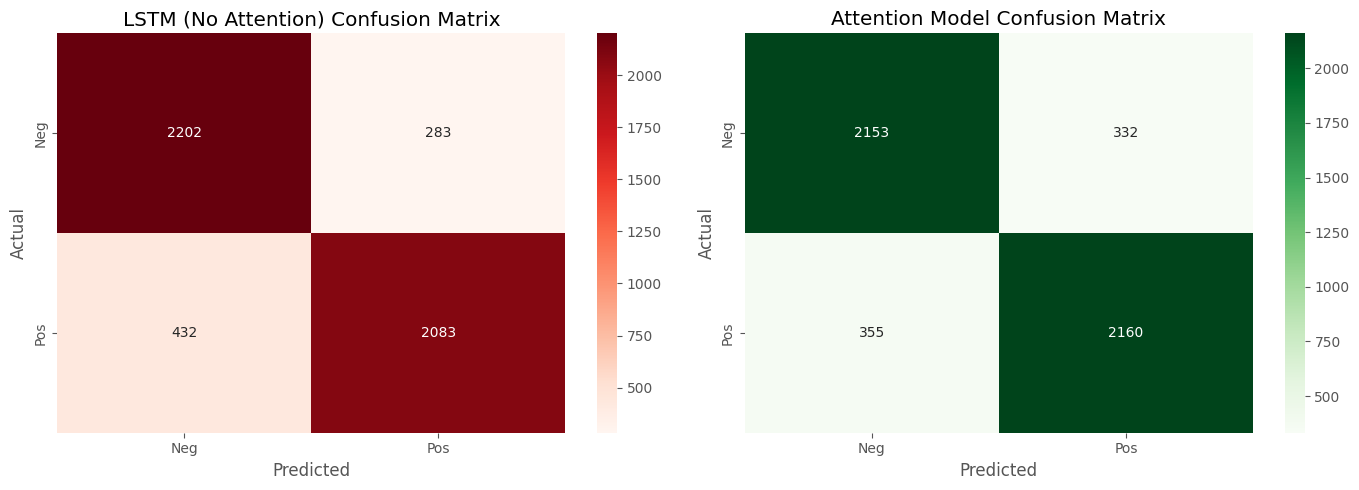


📝 REVIEW: "I expected to hate this movie given the terrible trailer but the acting was surprisingly brilliant and touching."
🤖 LSTM (No Attn): POSITIVE (100.00%)
🧠 Attention Model: POSITIVE (100.00%)

--- Why did Attention decide this? ---


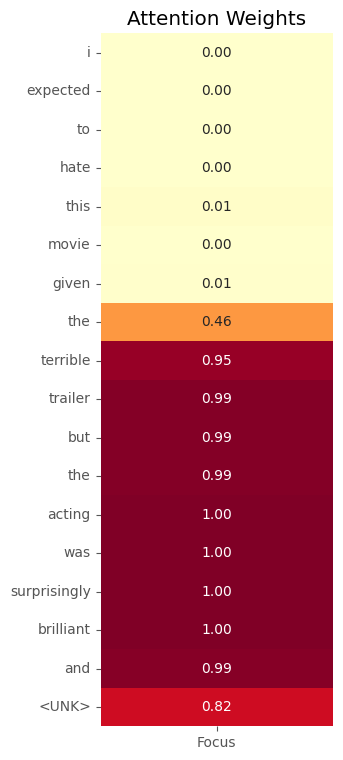


📝 REVIEW: "The special effects were amazing and the sound was great but the story was absolute trash and boring."
🤖 LSTM (No Attn): NEGATIVE (0.00%)
🧠 Attention Model: POSITIVE (99.90%)

--- Why did Attention decide this? ---


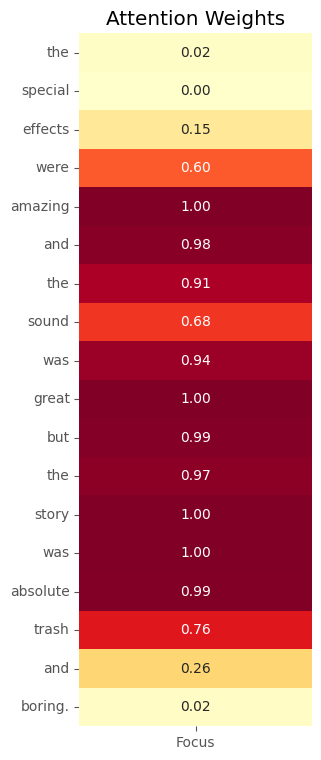

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

# ==========================================
# 1. CONFUSION MATRIX: NO-ATTENTION (LSTM)
# ==========================================
def plot_confusion_matrix_comparison(y_true, lstm_pred, attn_pred):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # LSTM Matrix
    cm_lstm = confusion_matrix(y_true, lstm_pred)
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Reds', ax=ax[0],
                xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    ax[0].set_title('LSTM (No Attention) Confusion Matrix')
    ax[0].set_ylabel('Actual')
    ax[0].set_xlabel('Predicted')

    # Attention Matrix
    cm_attn = confusion_matrix(y_true, attn_pred)
    sns.heatmap(cm_attn, annot=True, fmt='d', cmap='Greens', ax=ax[1],
                xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    ax[1].set_title('Attention Model Confusion Matrix')
    ax[1].set_ylabel('Actual')
    ax[1].set_xlabel('Predicted')

    plt.tight_layout()
    plt.show()

# Run the comparison
plot_confusion_matrix_comparison(y_true, lstm_pred, attn_pred)


# ==========================================
# 2. IMPROVED HEATMAP (VERTICAL & READABLE)
# ==========================================
def visualize_attention_readable(text, model, word2idx, max_len=50):
    """
    Vertical Heatmap: Best for readable text.
    Limits to first 'max_len' words to avoid clutter.
    """
    model.eval()

    # Preprocess text
    tokens = [word2idx.get(w, 1) for w in text.lower().split()]
    # Pad or trunc
    if len(tokens) >= 200: tokens = tokens[:200]
    else: tokens += [0] * (200 - len(tokens))

    x_tensor = torch.tensor([tokens], dtype=torch.long).to(DEVICE)

    # Predict
    preds, weights = model(x_tensor)
    weights = weights.squeeze().cpu().detach().numpy()

    # Get words back
    idx2word = {v: k for k, v in word2idx.items()}
    # We only grab the words that actually exist (ignore padding for the plot)
    real_len = len(text.split())
    if real_len > max_len: real_len = max_len # Limit for visibility

    words = [idx2word.get(t, "") for t in tokens[:real_len]]
    weights = weights[:real_len]

    # Normalize weights for clearer colors (0 to 1 scale relative to this sentence)
    weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)

    # PLOT: Vertical is much easier to read
    plt.figure(figsize=(3, len(words) * 0.5)) # Dynamic height based on sentence length
    sns.heatmap(weights.reshape(-1, 1), # Make it a column
                yticklabels=words,
                xticklabels=['Focus'],
                cmap='YlOrRd',
                cbar=False,
                annot=True, # Show the numbers too
                fmt=".2f")

    plt.title("Attention Weights")
    plt.yticks(rotation=0) # Keep text horizontal
    plt.show()


# ==========================================
# 3. MANUAL TEST SNIPPET (USER INPUT)
# ==========================================
def predict_manual_review(review_text):
    print("\n" + "="*50)
    print(f"📝 REVIEW: \"{review_text}\"")
    print("="*50)

    # Tokenize
    tokens = [word2idx.get(w, 1) for w in review_text.lower().split()]
    if len(tokens) >= 200: tokens = tokens[:200]
    else: tokens += [0] * (200 - len(tokens))
    x_tensor = torch.tensor([tokens], dtype=torch.long).to(DEVICE)

    # 1. LSTM Prediction
    lstm_model.eval()
    lstm_out = lstm_model(x_tensor)
    lstm_prob = torch.sigmoid(lstm_out).item()
    lstm_lbl = "POSITIVE" if lstm_prob > 0.5 else "NEGATIVE"

    # 2. Attention Prediction
    attn_model.eval()
    attn_out, _ = attn_model(x_tensor)
    attn_prob = torch.sigmoid(attn_out).item()
    attn_lbl = "POSITIVE" if attn_prob > 0.5 else "NEGATIVE"

    print(f"🤖 LSTM (No Attn): {lstm_lbl} ({lstm_prob*100:.2f}%)")
    print(f"🧠 Attention Model: {attn_lbl} ({attn_prob*100:.2f}%)")

    # Show Heatmap for this specific manual review
    print("\n--- Why did Attention decide this? ---")
    visualize_attention_readable(review_text, attn_model, word2idx)

# ==========================================
# TEST CASES
# ==========================================

# Case A: Complex Sarcasm (Hard for LSTM)
complex_review = "I expected to hate this movie given the terrible trailer but the acting was surprisingly brilliant and touching."
predict_manual_review(complex_review)

# Case B: Deceptive Start (Hard for LSTM)
deceptive_review = "The special effects were amazing and the sound was great but the story was absolute trash and boring."
predict_manual_review(deceptive_review)

--- Failure Analysis Mode ---


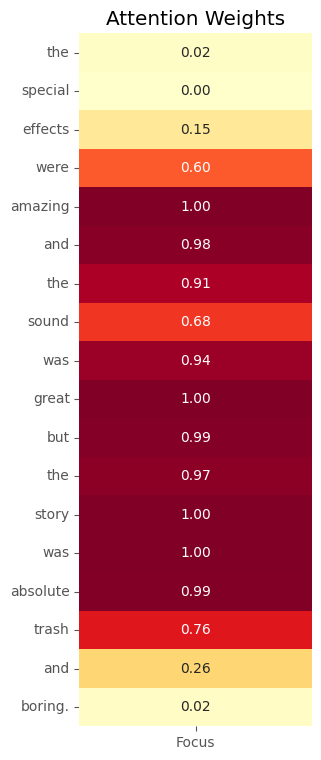

In [4]:
# Run this to confirm WHY it failed
# It will likely show high bars for 'amazing' and 'great'
complex_review = "The special effects were amazing and the sound was great but the story was absolute trash and boring."

print("--- Failure Analysis Mode ---")
visualize_attention_readable(complex_review, attn_model, word2idx)


⚡ Training Robust Multi-Head (Robust Mode)...
Epoch 1 | Train Loss: 0.5149 | Val Loss: 0.4090 | Val Acc: 81.60%
Epoch 2 | Train Loss: 0.3663 | Val Loss: 0.3456 | Val Acc: 85.00%
Epoch 3 | Train Loss: 0.3051 | Val Loss: 0.3203 | Val Acc: 85.88%
Epoch 4 | Train Loss: 0.2658 | Val Loss: 0.3129 | Val Acc: 86.88%
Epoch 5 | Train Loss: 0.2383 | Val Loss: 0.3047 | Val Acc: 86.72%
Epoch 6 | Train Loss: 0.2187 | Val Loss: 0.3080 | Val Acc: 86.58%

📝 Review: The special effects were amazing and the sound was great but the story was absolute trash and boring.
📊 Model Prediction: NEGATIVE (0.0927)


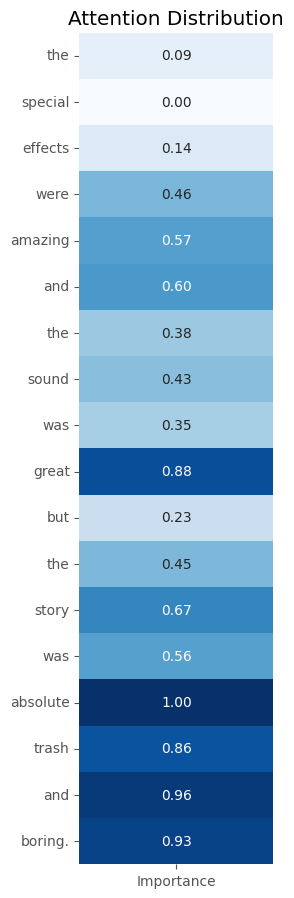

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 1. UPDATED CONFIG (PREVENTS OVERFITTING)
# ==========================================
# We limit epochs and add regularization
CONFIG['epochs'] = 6
CONFIG['weight_decay'] = 1e-4  # L2 Regularization (Prevents weights from hitting 1.0 instantly)

# ==========================================
# 2. MODEL DEFINITION (SAME AS BEFORE)
# ==========================================
class BiLSTMMultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(CONFIG['vocab_size'], CONFIG['embed_dim'], padding_idx=0)
        self.lstm = nn.LSTM(CONFIG['embed_dim'], CONFIG['hidden_dim'],
                            batch_first=True, bidirectional=True)

        self.attention_dim = CONFIG['hidden_dim'] * 2
        self.multihead_attn = nn.MultiheadAttention(embed_dim=self.attention_dim,
                                                    num_heads=4,
                                                    batch_first=True)
        self.fc = nn.Linear(self.attention_dim, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)

        # Multihead Attention
        attn_output, attn_weights = self.multihead_attn(lstm_out, lstm_out, lstm_out)

        # Pooling
        pooled_output = torch.mean(attn_output, dim=1)
        out = self.dropout(pooled_output)
        out = self.fc(out)

        # Return average weights across heads
        return out, attn_weights.mean(dim=1)

# ==========================================
# 3. TRAIN WITH REGULARIZATION
# ==========================================
def train_engine_robust(model, name):
    model = model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()

    # FIX: Added weight_decay to stop "Attention Collapse"
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

    print(f"\n⚡ Training {name} (Robust Mode)...")

    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            preds, _ = model(X_batch)
            loss = criterion(preds.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                preds, _ = model(X_batch)
                loss = criterion(preds.squeeze(), y_batch)
                val_loss += loss.item()
                predicted = (torch.sigmoid(preds.squeeze()) > 0.5).float()
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {correct/total*100:.2f}%")

    return model

# Train the robust model
model_robust = train_engine_robust(BiLSTMMultiHeadAttention(), "Robust Multi-Head")

# ==========================================
# 4. UPDATED VISUALIZATION (LOG SCALE FIX)
# ==========================================
def visualize_attention_soft(text, model, word2idx):
    model.eval()
    tokens = [word2idx.get(w, 1) for w in text.lower().split()]
    # Pad to 200
    if len(tokens) >= 200: tokens_pad = tokens[:200]
    else: tokens_pad = tokens + [0] * (200 - len(tokens))

    x_tensor = torch.tensor([tokens_pad], dtype=torch.long).to(DEVICE)

    # Predict
    preds, weights = model(x_tensor)
    prob = torch.sigmoid(preds).item()

    # Process Weights
    weights = weights.squeeze().cpu().detach().numpy()

    # Get actual words back
    idx2word = {v: k for k, v in word2idx.items()}
    real_len = len(text.split())
    words = [idx2word.get(t, "") for t in tokens[:real_len]]

    # Slice only the real words
    attentions = weights[:real_len]

    # VISUALIZATION FIX: Use Square Root or Log to soften the peaks
    # This prevents one word from taking 100% of the color
    attentions_soft = np.sqrt(attentions)
    # Re-normalize for plot (0-1 range)
    attentions_norm = (attentions_soft - attentions_soft.min()) / (attentions_soft.max() - attentions_soft.min() + 1e-9)

    print(f"\n📝 Review: {text}")
    print(f"📊 Model Prediction: {'POSITIVE' if prob > 0.5 else 'NEGATIVE'} ({prob:.4f})")

    # Plot
    plt.figure(figsize=(2.5, len(words) * 0.6))
    sns.heatmap(attentions_norm.reshape(-1, 1),
                yticklabels=words,
                xticklabels=['Importance'],
                cmap='Blues',  # Blue is often cleaner for "Professional" look
                cbar=False,
                annot=True,    # Show values
                fmt=".2f")
    plt.yticks(rotation=0)
    plt.title("Attention Distribution")
    plt.show()

# TEST WITH YOUR SENTENCE
complex_review = "The special effects were amazing and the sound was great but the story was absolute trash and boring."
visualize_attention_soft(complex_review, model_robust, word2idx)